<a href="https://colab.research.google.com/github/Hramchenko/Handwritting/blob/master/new_proffs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
print("Device " + torch.cuda.get_device_name(0))
device = torch.device("cuda:0")
#device = torch.device("cpu")
print(device)

Device Tesla K80
cuda:0


In [0]:
batch_size = 100

In [3]:
import sys
sys.path.append("./Handwritting/")
from IAMWords import IAMWords
image_width = 1500
image_height = 200
train_set = IAMWords("train", "./IAM/", batch_size=batch_size, line_height=image_height, line_width=image_width, scale=1)
test_set = IAMWords("test", "./IAM/", batch_size=batch_size, line_height=image_height, line_width=image_width, scale=1)

Reading ./IAM/words.train.pkl...
Reading finished
Reading ./IAM/words.test.pkl...
Reading finished


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.core.debugger import set_trace
%matplotlib inline
import matplotlib.pyplot as plt

In [0]:
class ConvLayer(nn.Module):
    def __init__(self, size, padding=1, pool_layer=nn.MaxPool2d(2, stride=2),
                 bn=False, dropout=False, activation_fn=nn.ReLU(), stride=1):
        super(ConvLayer, self).__init__()
        layers = []
        layers.append(nn.Conv2d(size[0], size[1], size[2], padding=padding, stride=stride))
        if pool_layer is not None:
            layers.append(pool_layer)
        if bn:
            layers.append(nn.BatchNorm2d(size[1]))
        if dropout:
            layers.append(nn.Dropout2d())
        layers.append(activation_fn)
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [0]:
class DeconvLayer(nn.Module):
    def __init__(self, size, padding=1, stride=1, 
                 bn=False, dropout=False, activation_fn=nn.ReLU(), output_padding=0):
        super(DeconvLayer, self).__init__()
        layers = []
        layers.append(nn.ConvTranspose2d(size[0], size[1], size[2], padding=padding, 
                                         stride=stride, output_padding=output_padding))
        if bn:
            layers.append(nn.BatchNorm2d(size[1]))
        if dropout:
            layers.append(nn.Dropout2d())
        layers.append(activation_fn)
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [0]:
class FullyConnected(nn.Module):
    def __init__(self, sizes, dropout=False, activation_fn=nn.Tanh):
        super(FullyConnected, self).__init__()
        layers = []
        
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if dropout:
                layers.append(nn.Dropout())
            layers.append(activation_fn())
        else: # нам не нужен дропаут и фнкция активации в последнем слое
            layers.append(nn.Linear(sizes[-2], sizes[-1]))
        
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

In [0]:
class FullyConnectedX(nn.Module):
    def __init__(self, sizes, dropout=False, activation_fn=nn.Tanh(), flatten=False, last_fn=None):
        super(FullyConnectedX, self).__init__()
        layers = []
        self.flatten = flatten
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if dropout:
                layers.append(nn.Dropout(dropout))
            layers.append(activation_fn) # нам не нужен дропаут и фнкция активации в последнем слое
        else: 
            layers.append(nn.Linear(sizes[-2], sizes[-1]))
        if last_fn is not None:
            layers.append(last_fn)
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        if self.flatten:
            x = x.view(x.shape[0], -1)
        return self.model(x)

In [0]:
batch = train_set.make_batch(use_binarization=False)
data, target = batch
target = target.to(device)
data = data/255.0
data = data.view(batch_size, 1, image_width, image_height).to(device)

In [0]:
class HTREncoder(nn.Module):
    def __init__(self, batchnorm=False, dropout=False):
        super(HTREncoder, self).__init__()
        
        self.convolutions = nn.Sequential(
        ConvLayer([1, 4, 3], padding=0, stride=2, bn=batchnorm, pool_layer=None),
        ConvLayer([4, 16, 3], padding=0, stride=2, bn=batchnorm, pool_layer=None),
        ConvLayer([16, 32, 3], padding=0, stride=2, bn=batchnorm, pool_layer=None),
        ConvLayer([32, 64, 3], padding=0, stride=2, bn=batchnorm, pool_layer=None),
        ConvLayer([64, 64, 1], padding=0, stride=(1,11), bn=batchnorm, pool_layer=None))
        
        #self.fc = FullyConnectedX([64*15*49, 64*49*3, 64*49], activation_fn=nn.ReLU())
    
    def forward(self, x):
        h = self.convolutions(x)
        h = h.squeeze(-1)
        #h = h.flatten(start_dim=1)
        #h = self.fc(h)
        #h = F.max_pool2d(h, [1, h.size(1)], padding=[0, 0])
        #h = h.permute([2, 3, 0, 1])[0]
        #h = h.permute([2, 3, 0, 1])
        
        return h
    

In [0]:
encoder = HTREncoder().to(device)

In [12]:
c = encoder(data)
c.shape

torch.Size([100, 64, 92])

In [13]:
64*15*49


47040

In [0]:
def to_onehot(x, n):
    one_hot = torch.zeros((x.shape[0], n)).to(device)
    one_hot.scatter_(1, x[:, None], 1.)
    if device is not None:
        one_hot = one_hot.to(device)
    return one_hot  

In [0]:
class HTRDecoderResult:
  
  def __init__(self):
    None

class HTRDecoder(nn.Module):
    def __init__(self, ntoken, encoded_width=92, encoded_height=64, batchnorm=False, dropout=True, rnn_type="LSTM"):
        super(HTRDecoder, self).__init__()
        self.ntoken = ntoken
        self.encoded_width = encoded_width
        self.encoded_height = encoded_height
        self.lstm_size = 256
        self.lstm_layers = 2
        self.rnn_type = rnn_type
        self.emb_size = 128
        features_size = self.encoded_height*encoded_width + self.emb_size
        from math import floor
        lstm_inp_size = floor(features_size*0.3)
        
        if rnn_type == "LSTM":
          self.rnn = nn.LSTM(lstm_inp_size, self.lstm_size, self.lstm_layers, dropout=0.3, bidirectional=False)
        else:
          self.rnn = nn.GRU(lstm_inp_size, self.lstm_size, self.lstm_layers, dropout=0.3, bidirectional=False)
        self.embedding = nn.Embedding(ntoken, self.emb_size)
        self.decoder = nn.Linear(1*self.lstm_size*1, ntoken)#*batch_size)
        self.drop = nn.Dropout(0.3)

        self.fc = FullyConnectedX([features_size, floor(features_size*0.7), floor(features_size*0.5), lstm_inp_size], activation_fn=nn.ReLU(), last_fn=nn.Tanh())
        
        self.attention = FullyConnectedX([self.lstm_size*2 + self.encoded_height*encoded_width, self.encoded_height*encoded_width*2,  self.encoded_width], activation_fn=nn.LeakyReLU(0.2), last_fn=nn.Tanh())
        self.attention_weights = None
    
    def forward(self, x, prev, hidden=None):
        x = self.drop(x).squeeze()
        if hidden is not None:
          
          hidden_m = hidden.permute(1, 0, 2)

          hidden_m = hidden_m.flatten(start_dim=1)
          
          attention_inp = torch.cat([x, hidden_m], dim=1).detach()
          self.attention_weights = self.attention(attention_inp)
          
          self.attention_weights = F.softmax(self.attention_weights, dim=1)
          
          self.attention_weights = self.attention_weights.repeat([1, self.encoded_height])
                  
          x = x * self.attention_weights

        emb = self.embedding(prev).squeeze().detach()
        
        
        x = torch.cat([x, emb], dim=1)
        
        x = self.fc(x)
        x = x.unsqueeze(0)
        
        result = HTRDecoderResult()
        result.rnn_input = x
        result.input_hidden = hidden
        
        x, hidden = self.rnn(x, hidden)
        x = x.squeeze(dim=0)
        x = self.drop(x)
        x = self.decoder(x)
        
        x = F.log_softmax(x, dim=1)
        
        result.x = x
        result.hidden = hidden
        
        return result
      
    def makeHidden(self):
      if self.rnn_type == "LSTM":
        h1 = torch.zeros(self.lstm_layers, batch_size, self.lstm_size).to(device)
        h2 = torch.zeros(self.lstm_layers, batch_size, self.lstm_size).to(device)
        return (h1, h2)
      else:
        h1 = torch.zeros(self.lstm_layers, batch_size, self.lstm_size).to(device)
        return h1
      
decoder = HTRDecoder(len(train_set.codes), rnn_type="GRU").to(device)

In [0]:
START = train_set.codes['<START>']
current_symbol = torch.LongTensor(batch_size, 1).to(device)
current_symbol[:, :] = START

In [0]:
def test(max_size=4):
  print("Testing...")
  
  freq = 20
  
  test_set.to_start(max_size)
  batch_idx = 0
  c_loss = 0
  START = train_set.start_code
  STOP = train_set.stop_code
  recognition_result = torch.LongTensor(batch_size, 30+1).to(device)
  old_symbol = torch.LongTensor(batch_size, 1).to(device)
  
  stop_symbol = torch.LongTensor(batch_size, 1).to(device)
  stop_symbol.fill_(STOP)
  
  test_loss = 0
  
  with torch.no_grad():  
    while True:
      batch = test_set.make_batch()
      if batch is None:
        break

      orig_data, target = batch
      data = orig_data/255.0
      data = data.view(batch_size, 1, image_width, image_height).to(device)
      target = target.to(device)
      hidden = decoder.makeHidden()    

      loss = 0
      enc = encoder(data)
      #print(enc.shape)
      s = enc.permute(1, 0, 2)
      #print(s.shape)
      s = s.flatten(start_dim=1).view(1, batch_size, -1)

      old_symbol[:, 0] = START

      for i in range(0, target.shape[1]):

        decoder_result = decoder(s, old_symbol, hidden)
        dec = decoder_result.x
        hidden = decoder_result.hidden

        recognition_result[:, i] = dec.topk(1, dim=1)[1].flatten().detach()
        old_symbol[:, 0] = target[:, i]

        loss += criterion(dec, target[:, i])
      c_loss += loss.item()/(target.shape[1] + 0)
      test_loss += loss.item()/(target.shape[1] + 0)
      if (batch_idx % freq == 0) and (batch_idx != 0):
        if True:#not use_teacher_forcing:
          for k in range(0, min(3, target.shape[0])):
              decoded = recognition_result[k,0:target.shape[1]]
              plt.imshow(orig_data[k].cpu(), cmap="gray")
              plt.show()
              print("  " + train_set.decode_word(target[k,:]) + " -> " + train_set.decode_word(decoded))
        c_loss /= freq 
        print("  Batch: " + str(batch_idx) + " Loss: " + str(c_loss))
        c_loss = 0
      batch_idx += 1  
  print("Test loss: %f" % (test_loss/batch_idx))   

In [0]:
# From https://github.com/aryopg/Professor_Forcing_Pytorch/blob/master/models/losses.py
class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size, input_length, symbs_cnt):
        super(Discriminator, self).__init__()
        
        self.embedding = nn.Embedding(symbs_cnt, 128)
        
        from math import floor
        self.hidden_cells = 256
        self.hidden_layers = 2
        
        self.hidden_size = hidden_size
        self.input_length = input_length
        self.rnn_layers = 2
        
        input_size = 512 + 1804 + 128
        gru_input_size = 256*2
        
        self.enc = FullyConnectedX([input_size, floor(input_size*0.7), gru_input_size], activation_fn=nn.ReLU())

        self.gru = nn.GRU(gru_input_size, hidden_size, self.rnn_layers)
        
        gru_out = hidden_size
        self.fc = FullyConnectedX([gru_out, floor(gru_out*0.7), floor(gru_out*0.3), 1], activation_fn=nn.ReLU())
        self.optimizer = optim.Adam(self.parameters(), lr=1e-4, weight_decay=0.00005)
        
    def zero_grad(self):
      self.optimizer.zero_grad()

    def apply(self, hidden, hidden_states, dec_inputs, dec_outputs, targets):
        emb_outputs = self.embedding(dec_outputs)#.permute(1, 0, 2)
        hidden_states = hidden_states.permute(1, 0, 2).flatten(start_dim=1)
        dec_inputs = dec_inputs.squeeze(0)
#         print(emb_outputs.shape)
#         print(hidden_states.shape)
#         print(dec_inputs.shape)
        full_input = torch.cat([hidden_states, dec_inputs, emb_outputs], dim=1)
        output = self.enc(full_input)
        output = output.unsqueeze(0)
        output, hidden = self.gru(output, hidden)
        output= output.squeeze(0)
        out = self.fc(output)
#         print(out.shape)
#         print(targets.shape)
        loss = F.binary_cross_entropy_with_logits(out, targets)
        return loss, hidden

    def makeHidden(self):
        return torch.zeros(self.rnn_layers, batch_size, self.hidden_size, device=device)

      
discriminator = Discriminator(256*2, 512, 10, len(train_set.codes)).to(device)      

In [0]:
def apply_discriminator(s, target, use_teacher_forcing, train_mode, discriminator_target):
  loss = 0
  START = train_set.start_code
  STOP = train_set.stop_code
  recognition_result = torch.LongTensor(batch_size, 30+1).to(device)
  old_symbol = torch.LongTensor(batch_size, 1).to(device)
  stop_symbol = torch.LongTensor(batch_size, 1).to(device)
  stop_symbol.fill_(STOP)
  old_symbol[:, 0] = START



  hidden = decoder.makeHidden()    
  discriminator_loss = 0
  discriminator_hidden = discriminator.makeHidden()

  for i in range(0, target.shape[1]):

    decoder_result = decoder(s, old_symbol, hidden)
    dec = decoder_result.x
    hidden = decoder_result.hidden

    decoder_outputs = dec.topk(1, dim=1)[1].flatten()

    
    if train_mode:
      dl, discriminator_hidden = discriminator.apply(discriminator_hidden.detach(), decoder_result.input_hidden.detach(),decoder_result.rnn_input.detach(), decoder_outputs.detach(), discriminator_target)
    else:
      dl, discriminator_hidden = discriminator.apply(discriminator_hidden, decoder_result.input_hidden, decoder_result.rnn_input, decoder_outputs, discriminator_target)
      
    if i != 0:
      discriminator_loss += dl

    recognition_result[:, i] = decoder_outputs.detach()
    if use_teacher_forcing:
      old_symbol[:, 0] = target[:, i]
    else:
      old_symbol[:, 0] = recognition_result[:, i]
    #import pdb; pdb.set_trace()

    loss += criterion(dec, target[:, i])
  if target.shape[1] > 1:
    discriminator_loss /= target.shape[1] - 1
  return (recognition_result, loss, discriminator_loss)

In [0]:
def apply_decoder(s, target, use_teacher_forcing):
  loss = 0
  START = train_set.start_code
  STOP = train_set.stop_code
  recognition_result = torch.LongTensor(batch_size, 30+1).to(device)
  old_symbol = torch.LongTensor(batch_size, 1).to(device)
  stop_symbol = torch.LongTensor(batch_size, 1).to(device)
  stop_symbol.fill_(STOP)
  old_symbol[:, 0] = START

  hidden = decoder.makeHidden()    

  for i in range(0, target.shape[1]):

    decoder_result = decoder(s, old_symbol, hidden)
    dec = decoder_result.x
    hidden = decoder_result.hidden

    recognition_result[:, i] = dec.topk(1, dim=1)[1].flatten().detach()
    if use_teacher_forcing:
      old_symbol[:, 0] = target[:, i]
    else:
      old_symbol[:, 0] = recognition_result[:, i]
    #import pdb; pdb.set_trace()

    loss += criterion(dec, target[:, i])
  return (recognition_result, loss)


batch_zeros = torch.zeros(batch_size, 1).to(device)
batch_ones = torch.ones(batch_size, 1).to(device)

Training epoch 0...
TF: True
  Batch: 100 Loss: 2.0168311417102815
TF: True
  Batch: 200 Loss: 2.0264943830172215
TF: True
  Batch: 300 Loss: 1.9182803213596347
Train loss: 1.972748
Testing...


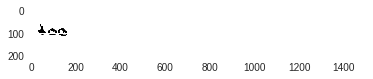

  too -> tho


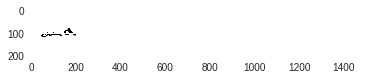

  and -> wnd


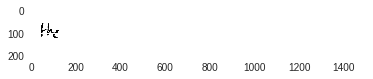

  the -> the
  Batch: 20 Loss: 2.0399491945902506
Test loss: 1.899273
Training epoch 1...


KeyboardInterrupt: ignored

In [21]:
encoder_optimizer = optim.Adam(encoder.parameters(), lr=1e-4, weight_decay=0.00005)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=1e-4, weight_decay=0.00005)
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=1e-4, weight_decay=0.00005)

criterion = nn.NLLLoss()

teacher_forcing_ratio = 1#0.5

from random import random

def train(epoch, max_size):
  print("Training epoch " + str(epoch) + "...")
  
  freq = 100
  
  train_set.to_start(max_size)
  batch_idx = 0
  c_loss = 0

  
  train_loss = 0
  
  while True:

    
    
    batch = train_set.make_batch()
    if batch is None:
      break
    encoder.zero_grad()
    decoder.zero_grad()
    
    orig_data, target = batch

    data = orig_data/255.0
    data = data.view(batch_size, 1, image_width, image_height).to(device)
    target = target.to(device)

    
    enc = encoder(data)
    #print(enc.shape)
    s = enc.permute(1, 0, 2)
    #print(s.shape)
    s = s.flatten(start_dim=1).view(1, batch_size, -1)
 

    use_teacher_forcing = True if random() < teacher_forcing_ratio else False

#    recognition_result, loss, discriminator_loss = apply_discriminator(s, target, use_teacher_forcing, True, batch_zeros)

    recognition_result, loss = apply_decoder(s, target, use_teacher_forcing)

      
      
    c_loss += loss.item()/(target.shape[1] + 0)
    train_loss += loss.item()/(target.shape[1] + 0)
    if (batch_idx % freq == 0) and (batch_idx != 0):
      print("TF: " + str(use_teacher_forcing))
      if False:#True:#not use_teacher_forcing:
        for k in range(0, min(3, target.shape[0])):
            decoded = recognition_result[k,0:target.shape[1]]
            plt.imshow(orig_data[k].cpu(), cmap="gray")
            plt.show()
            print("  " + train_set.decode_word(target[k,:]) + " -> " + train_set.decode_word(decoded))
      c_loss /= freq 
      print("  Batch: " + str(batch_idx) + " Loss: " + str(c_loss))
      c_loss = 0
    loss.backward()
    #grad_clip = 0.1
    #torch.nn.utils.clip_grad_norm_(encoder.parameters(), grad_clip)
    #torch.nn.utils.clip_grad_norm_(decoder.parameters(), grad_clip)
    encoder_optimizer.step()
    decoder_optimizer.step()
    batch_idx += 1
  print("Train loss: %f"%(train_loss/batch_idx))

for i in range(0, 100):
  max_size = 5
  train(i, max_size)
  test(max_size)

In [0]:
raise Exception()

In [0]:
encoder_optimizer = optim.Adam(encoder.parameters(), lr=1e-4, weight_decay=0.00005)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=1e-4, weight_decay=0.00005)

criterion = nn.NLLLoss()

teacher_forcing_ratio = 1#0.5

from random import random


def train(epoch, max_size):
  print("Training epoch " + str(epoch) + "...")
  
  freq = 100
  
  train_set.to_start(max_size)
  batch_idx = 0
  c_loss = 0

  
  train_loss = 0
  
  while True:

    
    
    batch = train_set.make_batch()
    if batch is None:
      break
    encoder.zero_grad()
    decoder.zero_grad()
    
    orig_data, target = batch

    data = orig_data/255.0
    data = data.view(batch_size, 1, image_width, image_height).to(device)
    target = target.to(device)

    
    enc = encoder(data)
    #print(enc.shape)
    s = enc.permute(1, 0, 2)
    #print(s.shape)
    s = s.flatten(start_dim=1).view(1, batch_size, -1)
 

    use_teacher_forcing = True if random() < teacher_forcing_ratio else False

    loss = 0
    START = train_set.start_code
    STOP = train_set.stop_code
    recognition_result = torch.LongTensor(batch_size, 30+1).to(device)
    old_symbol = torch.LongTensor(batch_size, 1).to(device)
    stop_symbol = torch.LongTensor(batch_size, 1).to(device)
    stop_symbol.fill_(STOP)
    old_symbol[:, 0] = START
    
    
 
    hidden = decoder.makeHidden()    

    for i in range(0, target.shape[1]):

      decoder_result = decoder(s, old_symbol, hidden)
      dec = decoder_result.x
      hidden = decoder_result.hidden
      
      recognition_result[:, i] = dec.topk(1, dim=1)[1].flatten().detach()
      if use_teacher_forcing:
        old_symbol[:, 0] = target[:, i]
      else:
        old_symbol[:, 0] = recognition_result[:, i]
      #import pdb; pdb.set_trace()

      loss += criterion(dec, target[:, i])
      
      
      
    c_loss += loss.item()/(target.shape[1] + 0)
    train_loss += loss.item()/(target.shape[1] + 0)
    if (batch_idx % freq == 0) and (batch_idx != 0):
      print("TF: " + str(use_teacher_forcing))
      if False:#True:#not use_teacher_forcing:
        for k in range(0, min(3, target.shape[0])):
            decoded = recognition_result[k,0:target.shape[1]]
            plt.imshow(orig_data[k].cpu(), cmap="gray")
            plt.show()
            print("  " + train_set.decode_word(target[k,:]) + " -> " + train_set.decode_word(decoded))
      c_loss /= freq 
      print("  Batch: " + str(batch_idx) + " Loss: " + str(c_loss))
      c_loss = 0
    loss.backward()
    #grad_clip = 0.1
    #torch.nn.utils.clip_grad_norm_(encoder.parameters(), grad_clip)
    #torch.nn.utils.clip_grad_norm_(decoder.parameters(), grad_clip)
    encoder_optimizer.step()
    decoder_optimizer.step()
    batch_idx += 1
  print("Train loss: %f"%(train_loss/batch_idx))

for i in range(0, 100):
  max_size = 5
  train(i, max_size)
  test(max_size)

In [0]:
encoder_optimizer = optim.Adam(encoder.parameters(), lr=1e-4, weight_decay=0.00005)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=1e-4, weight_decay=0.00005)

criterion = nn.NLLLoss()

teacher_forcing_ratio = 1#0.5

from random import random


def train(epoch, max_size):
  print("Training epoch " + str(epoch) + "...")
  
  freq = 100
  
  train_set.to_start(max_size)
  batch_idx = 0
  c_loss = 0
  START = train_set.start_code
  STOP = train_set.stop_code
  recognition_result = torch.LongTensor(batch_size, 30+1).to(device)
  old_symbol = torch.LongTensor(batch_size, 1).to(device)
  
  stop_symbol = torch.LongTensor(batch_size, 1).to(device)
  stop_symbol.fill_(STOP)
  
  train_loss = 0
  
  while True:
    batch = train_set.make_batch()
    if batch is None:
      break
    encoder.zero_grad()
    decoder.zero_grad()
    
    orig_data, target = batch

    data = orig_data/255.0
    data = data.view(batch_size, 1, image_width, image_height).to(device)
    target = target.to(device)
    hidden = decoder.makeHidden()    

    loss = 0
    enc = encoder(data)
    #print(enc.shape)
    s = enc.permute(1, 0, 2)
    #print(s.shape)
    s = s.flatten(start_dim=1).view(1, batch_size, -1)
    
    old_symbol[:, 0] = START
    use_teacher_forcing = True if random() < teacher_forcing_ratio else False

    for i in range(0, target.shape[1]):

      decoder_result = decoder(s, old_symbol, hidden)
      dec = decoder_result.x
      hidden = decoder_result.hidden
      
      recognition_result[:, i] = dec.topk(1, dim=1)[1].flatten().detach()
      if use_teacher_forcing:
        old_symbol[:, 0] = target[:, i]
      else:
        old_symbol[:, 0] = recognition_result[:, i]
      #import pdb; pdb.set_trace()

      loss += criterion(dec, target[:, i])
    c_loss += loss.item()/(target.shape[1] + 0)
    train_loss += loss.item()/(target.shape[1] + 0)
    if (batch_idx % freq == 0) and (batch_idx != 0):
      print("TF: " + str(use_teacher_forcing))
      if False:#True:#not use_teacher_forcing:
        for k in range(0, min(3, target.shape[0])):
            decoded = recognition_result[k,0:target.shape[1]]
            plt.imshow(orig_data[k].cpu(), cmap="gray")
            plt.show()
            print("  " + train_set.decode_word(target[k,:]) + " -> " + train_set.decode_word(decoded))
      c_loss /= freq 
      print("  Batch: " + str(batch_idx) + " Loss: " + str(c_loss))
      c_loss = 0
    loss.backward()
    #grad_clip = 0.1
    #torch.nn.utils.clip_grad_norm_(encoder.parameters(), grad_clip)
    #torch.nn.utils.clip_grad_norm_(decoder.parameters(), grad_clip)
    encoder_optimizer.step()
    decoder_optimizer.step()
    batch_idx += 1
  print("Train loss: %f"%(train_loss/batch_idx))

for i in range(0, 100):
  max_size = 5
  train(i, max_size)
  test(max_size)

In [0]:
encoder_optimizer = optim.Adam(encoder.parameters(), lr=1e-4, weight_decay=0.00005)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=1e-4, weight_decay=0.00005)

criterion = nn.NLLLoss()

teacher_forcing_ratio = 1#0.5

from random import random


def train(epoch, max_size):
  print("Training epoch " + str(epoch) + "...")
  
  freq = 100
  
  train_set.to_start(max_size)
  batch_idx = 0
  c_loss = 0
  
  train_loss = 0
  
  while True:
    batch = train_set.make_batch()
    if batch is None:
      break
    encoder.zero_grad()
    decoder.zero_grad()
    
    orig_data, target = batch

    data = orig_data/255.0
    data = data.view(batch_size, 1, image_width, image_height).to(device)
    target = target.to(device)
    hidden = decoder.makeHidden()    

    loss = 0
    enc = encoder(data)
    #print(enc.shape)
    s = enc.permute(1, 0, 2)
    #print(s.shape)
    s = s.flatten(start_dim=1).view(1, batch_size, -1)
    
    use_teacher_forcing = True if random() < teacher_forcing_ratio else False
    recognition_result, loss = decode(target, s, use_teacher_forcing)
    c_loss += loss.item()/(target.shape[1] + 0)

    train_loss += loss.item()/(target.shape[1] + 0)
    if (batch_idx % freq == 0) and (batch_idx != 0):
      print("TF: " + str(use_teacher_forcing))
      if False:#True:#not use_teacher_forcing:
        for k in range(0, min(3, target.shape[0])):
            decoded = recognition_result[k,0:target.shape[1]]
            plt.imshow(orig_data[k].cpu(), cmap="gray")
            plt.show()
            print("  " + train_set.decode_word(target[k,:]) + " -> " + train_set.decode_word(decoded))
      c_loss /= freq 
      print("  Batch: " + str(batch_idx) + " Loss: " + str(c_loss))
      c_loss = 0
    loss.backward()
    
    # Не убирать
    grad_clip = 0.1
    torch.nn.utils.clip_grad_norm_(encoder.parameters(), grad_clip)
    torch.nn.utils.clip_grad_norm_(decoder.parameters(), grad_clip)
    encoder_optimizer.step()
    decoder_optimizer.step()
    batch_idx += 1
  print("Train loss: %f"%(train_loss/batch_idx))

for i in range(0, 100):
  max_size = 5
  train(i, max_size)
  test(max_size)

In [0]:
def decode(target, s, use_teacher_forcing):
  START = train_set.start_code
  #STOP = train_set.stop_code
  recognition_result = torch.LongTensor(batch_size, 30+1).to(device)
  old_symbol = torch.LongTensor(batch_size, 1).to(device)
  
  #stop_symbol = torch.LongTensor(batch_size, 1).to(device)
  #stop_symbol.fill_(STOP)
  
  hidden = decoder.makeHidden()    

  loss = 0

  old_symbol[:, 0] = START

  for i in range(0, target.shape[1]):

    decoder_result = decoder(s, old_symbol, hidden)
    dec = decoder_result.x
    hidden = decoder_result.hidden


    recognition_result[:, i] = dec.topk(1, dim=1)[1].flatten().detach()
    if use_teacher_forcing:
      old_symbol = target[:, i]
    else:
      old_symbol = recognition_result[:, i].detach()

    loss += criterion(dec, target[:, i])
      
    return (recognition_result, loss)  
      
  